In [1]:
import pandas as pd
import pybasilica.run as run
import torch
import pyro
import numpy as np
import seaborn as sns
import sklearn.metrics

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/basilica-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_path = "test_simul_counts.csv"
m_g = pd.read_csv(m_path)
m = m_g.drop(["groups", "groups_rare"], axis=1)
g = m_g["groups"].tolist()
g_rare = m_g["groups_rare"].tolist()
ref_path = "COSMIC_filt.csv"
cosmic = pd.read_csv(ref_path, index_col=0)
k_list = [4]  # true is 4
cluster = [4]  # true is 3 + 1 rare 

In [27]:
one = run.fit(
    x=m, 
    k_list=k_list, 
    lr=0.005, 
    n_steps=5000, 
    cluster=cluster, 
    beta_fixed=cosmic.loc[["SBS1","SBS5"]], 
    hyperparameters={"alpha_sigma":0.15, "alpha_p_sigma":0.6, "alpha_p_conc0":0.6, "alpha_p_conc1":0.6},
    enforce_sparsity = False, 
    reg_weight = 0., 
    store_parameters=False, 
    verbose = False, 
    save_runs_seed=True,
    seed=[92],
    new_hier = False, 
    nonparametric = False
    )

obj = one[0] 
# 5 = n_samples, 1,2 + 2 = n_sigs, 2 = n_groups 

Running model with 4 signatures, 4 groups and 92 seed

N parameters 1312


In [30]:
alpha_prior = torch.tensor(0.3)
alpha_sigma = torch.tensor(0.1)
q_05 = alpha_prior - alpha_sigma * alpha_prior
q_95 = alpha_prior + alpha_sigma * alpha_prior
alpha_sigma_corr = (q_95 - q_05) / (2 * pyro.distributions.Normal(alpha_prior, 1).icdf(torch.tensor(0.95)))

In [31]:
alpha_sigma_corr 

tensor(0.0154)

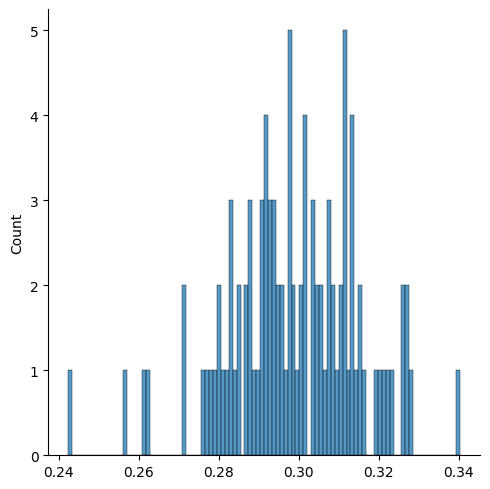

In [33]:
sns.displot(pyro.distributions.Normal(0.3, alpha_sigma_corr).sample((100,)).tolist(), bins=100)

In [28]:
print({i:obj.groups.count(i) for i in set(obj.groups)})
print({i:g_rare.count(i) for i in set(g_rare)})
print({i:g.count(i) for i in set(g)} ) 

print("\n", obj.k_denovo)


{0: 93, 1: 8, 2: 47, 3: 2}
{1: 55, 2: 45, 3: 42, 4: 8}
{1: 63, 2: 45, 3: 42}

 4


In [29]:
print(sklearn.metrics.normalized_mutual_info_score(obj.groups, g_rare))
print(sklearn.metrics.adjusted_rand_score(obj.groups, g_rare), "\n")
print(sklearn.metrics.normalized_mutual_info_score(obj.groups, g))
print(sklearn.metrics.adjusted_rand_score(obj.groups, g)) 


0.4678597936028674
0.3398825366103199 

0.48880997575824847
0.375070226657631


In [18]:
idxs = [i for i, v in enumerate(g_rare) if v == 4]
print([v for i, v in enumerate(obj.groups) if i in idxs])


[2, 2, 2, 2, 2, 2, 2, 2]


<Axes: >

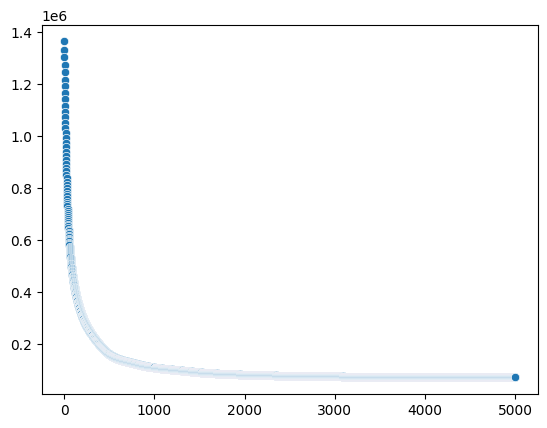

In [19]:
sns.scatterplot(x=range(len(obj.losses)), y=obj.losses)

<Axes: >

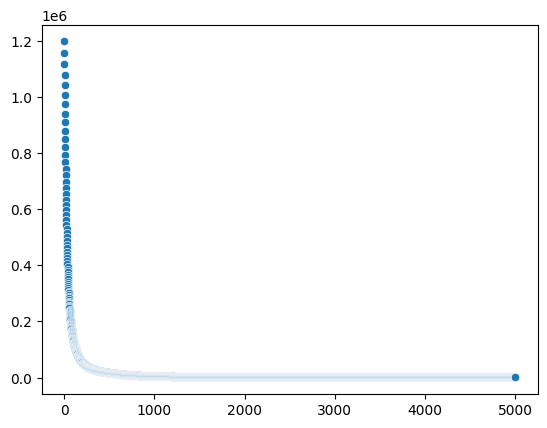

In [20]:
sns.scatterplot(x=range(len(obj.gradient_norms["alpha_prior_param"])), y=obj.gradient_norms["alpha_prior_param"]) 

In [21]:
try: sns.scatterplot(x=range(len(obj.gradient_norms["alpha_noise_param"])), y=obj.gradient_norms["alpha_noise_param"])
except: print()

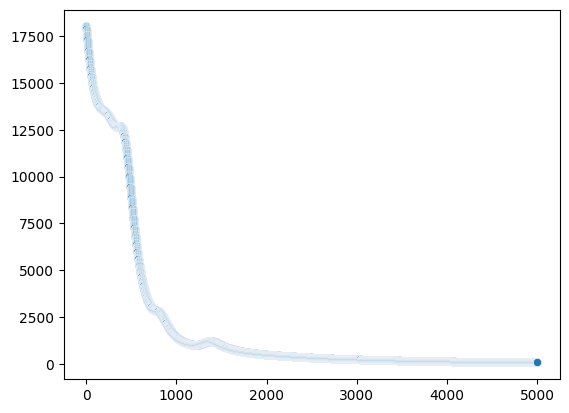

In [22]:
try: sns.scatterplot(x=range(len(obj.gradient_norms["beta_denovo"])), y=obj.gradient_norms["beta_denovo"])
except: print()

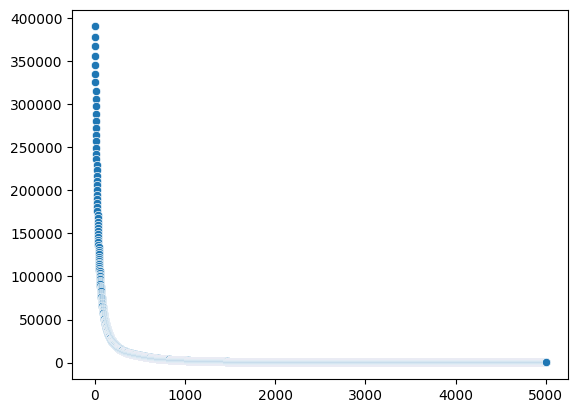

In [23]:
try: sns.scatterplot(x=range(len(obj.gradient_norms["pi_param"])), y=obj.gradient_norms["pi_param"]) 
except: print()

<Axes: >

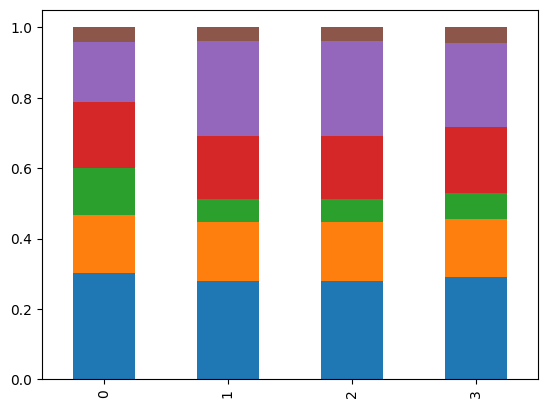

In [24]:
pd.DataFrame(np.array(obj.alpha_prior), columns=obj.alpha.columns).plot.bar(stacked=True, legend=False) 

<Axes: >

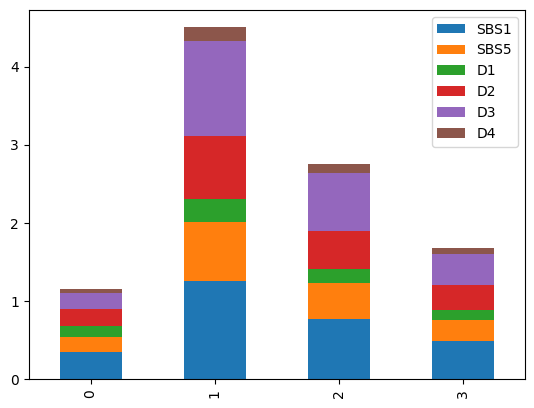

In [25]:
pd.DataFrame(np.array(obj.alpha_prior_unn), columns=obj.alpha.columns).plot.bar(stacked=True)

In [ ]:
# print(obj.alpha_prior) 
# print(obj.init_params["alpha_t_param"]) 
# print(pyro.param("alpha_prior_param")) 

In [15]:
try:
    for gid in set(obj.groups):
        tmp = [i for i, v in enumerate(obj.groups) if v == gid]
        pd.DataFrame(np.array(obj.alpha_noise), columns=obj.alpha.columns).iloc[tmp].plot.bar(stacked=True) 
    # pd.DataFrame(np.array(obj.alpha_noise), columns=obj.alpha.columns).iloc[idxs].plot.bar(stacked=True, legend=False)
except:
    print() 

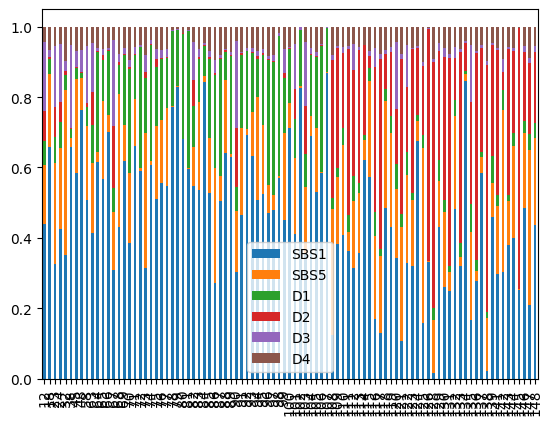

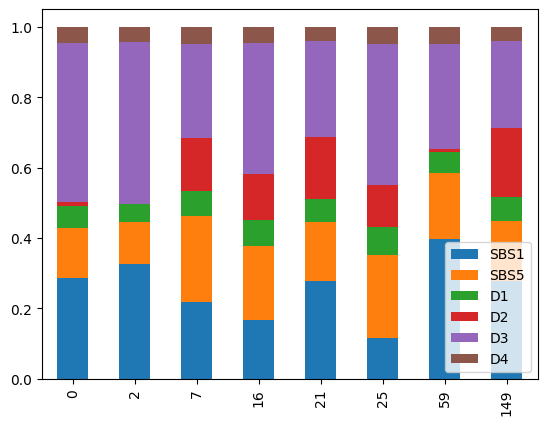

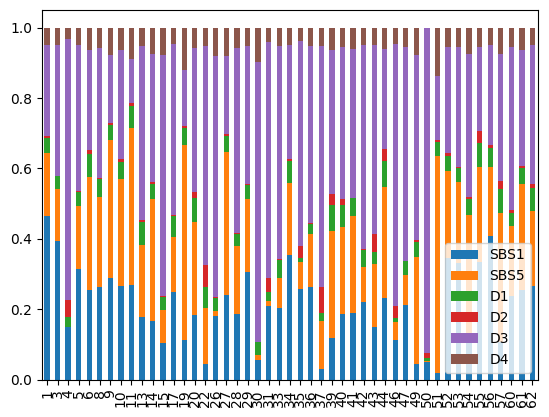

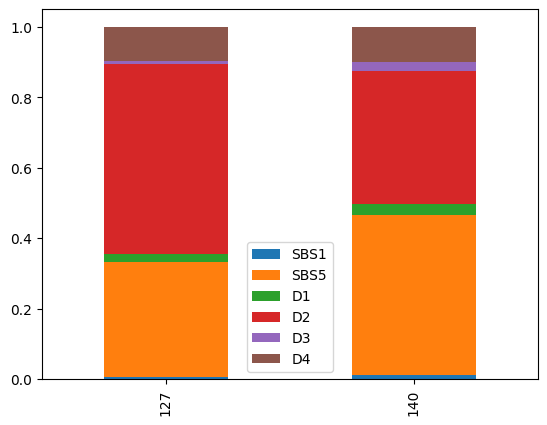

In [26]:
for gid in set(obj.groups):
    tmp = [i for i, v in enumerate(obj.groups) if v == gid]
    # tmp = [i for i, v in enumerate(obj.groups) if (v == gid and i in idxs)]
    if len(tmp) == 0: continue
    pd.DataFrame(np.array(obj.alpha), columns=obj.alpha.columns, index=obj.alpha.index).iloc[tmp].plot.bar(stacked=True)
# obj.alpha.iloc[idxs].plot.bar(stacked=True, legend=False)


In [ ]:
print(obj.alpha_noise.min()) 
print(obj.alpha_noise.max()) 

In [94]:
obj.pi

[0.32568123702070195,
 0.022973795572309705,
 0.3256747497592424,
 0.32567021764774595]

In [ ]:
a = torch.tensor([-.3,.3,.3,.5])
print(torch.min(a))
print(a / torch.sum(a)) 
print(a - torch.min(a)) 
print( (a - torch.min(a)) / torch.sum(a - torch.min(a)) ) 

In [ ]:
[0, .6, .6, .8]

In [ ]:
isinstance(obj.pi, torch.Tensor)

In [ ]:
obj.post_probs

In [ ]:
obj.groups 

In [ ]:
obj.alpha

In [ ]:
obj.k_denovo

In [ ]:
obj.k_fixed

In [ ]:
obj.alpha_prior_unn

In [ ]:
obj.alpha_noise

In [ ]:
obj.alpha_unn + obj.alpha_noise 

In [ ]:
obj.alpha 

In [ ]:
from pyro import distributions as distr
import seaborn as sns
import numpy as np

# sns.displot(distr.HalfNormal(obj.hyperparameters["alpha_var"]).sample_n(1000).tolist())
# sns.displot(distr.Exponential(obj.hyperparameters["exp_rate"]).sample_n(1000).tolist()) 
vars = distr.Normal(0, 0.005).sample_n(50).tolist()
centrs = [distr.Normal(0.5, np.abs(v_i)).sample().tolist() for v_i in vars]

pl = sns.scatterplot(x=vars, y=centrs)
pl.axhline(0.5-0.05)
pl.axhline(0.5+0.05)

# sns.displot(vars)
# sns.displot(distr.Normal(0, 0.01).sample_n(1000).tolist()) 

In [ ]:
sns.displot(distr.Normal(0, 0.005).sample_n(1000).tolist()) 

In [ ]:
x2 = one.epsilon.astype(int)

In [ ]:
two = run.fit(
    x=x2, 
    k_list=[1,2,3,4,5], 
    lr=0.05, 
    n_steps=500, 
    enumer=False, 
    cluster=None, 
    groups=None, 
    beta_fixed=None, 
    compile_model = False, 
    CUDA = False, 
    enforce_sparsity = False, 
    regularizer = "cosine", 
    reg_weight = 1, 
    reg_bic = False, 
    store_parameters=False, 
    verbose=False, 
    stage = "two"
    )

In [ ]:
two.alpha

In [ ]:
import torch
import numpy as np

m1 = torch.tensor(m.values).float()
alpha1 = torch.tensor(one.alpha.values).float()
a1 = torch.matmul(torch.diag(torch.sum(m1, axis=1)), alpha1)

m2 = torch.tensor(x2.values).float()
alpha2 = torch.tensor(two.alpha.values).float()
a2 = torch.matmul(torch.diag(torch.sum(m2, axis=1)), alpha2)

b1 = torch.sum(a1, 1).unsqueeze(-1)
b2 = torch.sum(a2, 1).unsqueeze(-1)
b3 = b1 + b2

alpha1 = a1 / b3
alpha2 = a2 / b3

In [ ]:
sample_names = list(one.alpha.index)
fixed_names = list(one.alpha.columns)
denovo_names = list(two.alpha.columns)
alpha1 = pd.DataFrame(np.array(alpha1), index=sample_names, columns=fixed_names)
alpha2 = pd.DataFrame(np.array(alpha2), index=sample_names, columns=denovo_names)
alpha = pd.concat([alpha1, alpha2], axis=1)

In [ ]:
alpha

In [ ]:
torch.sum(torch.tensor(alpha.values).float(), 1).unsqueeze(-1)